In [81]:
import os
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import random


num_classes = 80  # 分类数量
batch_size = 2
num_epochs = 10  # 训练轮次
lr = 0.02
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 读取并展示图片

file_root = "D:/aaaaaaaaaaaaaaaaa/nus/fyp/Q2A-master/Q2A-master/encoder/configs/train"
classes = ['aircon_utr3b','airfryer_gye82','airfryer_pe2j7','airfryer_w9rzm','bicycle_g8h94','blender_d4og8','blender_tg2xq','blender_zuw28','camera_4paj0','camera_9awdp','camera_a409h','coffeemachine_d2stw','dehydrator_jvzgp','diffuser_lxcd4','dryer_am5jp','dryer_d4uqs','dryer_vc1kl','inductioncooker_bjye3','inductioncooker_v0jzx','inductioncooker_veifx','kiettle_rc3pf','kitchenscale_025qs','kitchenscale_7shbw','kitchenscale_jsgih','kitchenscale_pqejy','kitchenscale_wk150','kitchentimer_fr3ld','kitchentimer_nr0vk','lightstand_ro8fj','microwave_clhpa','microwave_etrc9','microwave_gz61t','microwave_h43qm','microwave_kflra','microwave_ljbak','microwave_m0fgh','microwave_m5vq3','microwave_r5h7q','microwave_y3fpx','microwave_y693a','microwave_yw0gr','microwave_znl6u','mixer_muhce','oven_968hd','oven_e7fsy','oven_g6xvo','oven_lhap5','oven_un32d','oven_wa67l','oven_wn85g','printer_5jpry','printer_bf69n','rangehood_2pk8j','ricecooker_26ax0','ricecooker_5apek','ricecooker_af46c','ricecooker_tlvys','ricecooker_tomn0','ricecooker_zxuqy','toaster_ja9zg','toaster_xwc03','treadmill_npdev','treadmill_nu3ob','vacuum_1csuz','washingmachine_735oe','washingmachine_8fzkt','washingmachine_dz980','washingmachine_gxblk','washingmachine_h4n8j','washingmachine_kc4eb','washingmachine_kstcf','washingmachine_m79j0','washingmachine_tyap1','washingmachine_ujs4r','washingmachine_uomyf','washingmachine_wtbih','watch_0ku25','watch_c8zhg','watch_yw2mz','waterpurifier_b2j3o']
nums = [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2]  # 每种类别的个数

def read_data(path):
    file_name = os.listdir(path)  # 获取所有文件的文件名称
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    # 每个类别随机抽取20%作为测试集
    train_num = [int(num * 1 / 2) for num in nums]
    test_num = [nums[i] - train_num[i] for i in range(len(nums))]

    for idx, f_name in enumerate(file_name):  # 每个类别一个idx，即以idx作为标签
        im_dirs = path + '/' + f_name+'/images'
        im_path = os.listdir(im_dirs)  # 每个不同类别图像文件夹下所有图像的名称

        index = list(range(len(im_path)))
        random.shuffle(index)  # 打乱顺序
        im_path_ = list(np.array(im_path)[index])
        test_path = im_path_[:test_num[idx]]  # 测试数据的路径
        train_path = im_path_[test_num[idx]:]  # 训练数据的路径

        for img_name in train_path:
            # 会读到desktop.ini,要去掉
            if img_name == 'desktop.ini':
                continue
            img = Image.open(im_dirs + '/' + img_name).convert("RGB")  # img shape: (120, 85, 3) 高、宽、通道
            # 对图片进行变形
            img = img.resize((256, 256), Image.ANTIALIAS)  # 宽、高
            train_data.append(img)
            train_labels.append(idx)

        for img_name in test_path:
            # 会读到desktop.ini,要去掉
            if img_name == 'desktop.ini':
                continue
            img = Image.open(im_dirs + '/' + img_name).convert("RGB")  # img shape: (120, 85, 3) 高、宽、通道
            # 对图片进行变形
            img = img.resize((256, 256), Image.ANTIALIAS)  # 宽、高
            test_data.append(img)
            test_labels.append(idx)

    print('训练集大小：', len(train_data), ' 测试集大小：', len(test_data))

    return train_data, train_labels, test_data, test_labels

# 一次性读取全部的数据
train_data, train_labels, test_data, test_labels = read_data(file_root)

E:\anaconda\envs\dl\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
E:\anaconda\envs\dl\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.


训练集大小： 86  测试集大小： 80


In [69]:
transform = transforms.Compose(
    [transforms.ToTensor(),  # 变为tensor
     # 对数据按通道进行标准化，即减去均值，再除以方差, [0-1]->[-1,1]
     transforms.Normalize(mean=[0.4686, 0.4853, 0.5193], std=[0.1720, 0.1863, 0.2175])
     ]
)


# 自定义Dataset类实现每次取出图片，将PIL转换为Tensor
class MyDataset(Dataset):
    def __init__(self, data, label, trans):
        self.len = len(data)
        self.data = data
        self.label = label
        self.trans = trans

    def __getitem__(self, index):  # 根据索引返回数据和对应的标签
        return self.trans(self.data[index]), self.label[index]

    def __len__(self):
        return self.len


# 调用自己创建的Dataset
train_dataset = MyDataset(train_data, train_labels, transform)
test_dataset = MyDataset(test_data, test_labels, transform)

# 生成data loader
train_iter = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)
test_iter = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)


def train(net, data_loader, device):
    net.train()  # 指定为训练模式
    train_batch_num = len(data_loader)
    total_loss = 0.0
    correct = 0  # 记录共有多少个样本被正确分类
    sample_num = 0

    # 遍历每个batch进行训练
    for data, target in data_loader:
        # 将图片和标签放入指定的device中
        data = data.to(device)
        target = target.to(device)
        # 将当前梯度清零
        optimizer.zero_grad()
        # 使用模型计算出结果
        y_hat = net(data)
        # 计算损失
        loss_ = loss(y_hat, target)
        # 进行反向传播
        loss_.backward()
        optimizer.step()
        total_loss += loss_.item()
        cor = (torch.argmax(y_hat, 1) == target).sum().item()
        correct += cor
        # 累加当前的样本总数
        sample_num += target.shape[0]
        print('loss: %.4f  acc: %.4f' % (loss_.item(), cor / target.shape[0]))
    # 平均loss和准确率
    loss_ = total_loss / train_batch_num
    acc = correct / sample_num
    return loss_, acc


# 测试
def test(net, data_loader, device):
    net.eval()  # 指定当前模式为测试模式（针对BN层和dropout层）
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    # 指定不进行梯度计算（没有反向传播也会计算梯度，增大GPU开销
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            output = net(data)
            loss_ = loss(output, target)
            total_loss += loss_.item()
            correct += (torch.argmax(output, 1) == target).sum().item()
            sample_num += target.shape[0]
    loss_ = total_loss / test_batch_num
    acc = correct / sample_num
    return loss_, acc

In [3]:
#残差网络块
#每个残差块都是两层
#默认3*3卷积下padding为1，则大小不会变化，如变化则是步长引起的。
class ResidualBlock(torch.nn.Module):
    def __init__(self, nin, nout, size, stride=1, shortcut=True):
        super(ResidualBlock, self).__init__()
        #两层卷积层
        #不同步长只有第一层卷积层不同
        self.block1 = torch.nn.Sequential(torch.nn.Conv2d(nin, nout, size, stride, padding=1),
                                          torch.nn.BatchNorm2d(nout),
                                          torch.nn.ReLU(inplace=True),
                                          torch.nn.Conv2d(nout, nout, size, 1, padding=1),
                                          torch.nn.BatchNorm2d(nout))
        self.shortcut = shortcut
        #解决通道数变化以及步长不为1引起的图片大小的变化
        self.block2 = torch.nn.Sequential(torch.nn.Conv2d(nin, nout, size, stride, 1),
                                          torch.nn.BatchNorm2d(nout))
        self.relu = torch.nn.ReLU(inplace=True)

    def forward(self, input):
        x = input
        out = self.block1(x)
        '''''若输入输出维度相等直接相加，不相等改变输入的维度--包括大小和通道'''
        if self.shortcut:
            out = x + out
        else:
            out = out + self.block2(x)
        out = self.relu(out)
        return out


#定义给定的残差结构
class resnet(torch.nn.Module):
    def __init__(self):
        super(resnet, self).__init__()
        self.block = torch.nn.Sequential(torch.nn.Conv2d(3, 64, 3, stride=1, padding=1),
                                         torch.nn.BatchNorm2d(64),
                                         torch.nn.ReLU())
        #t表示2个相同的残差块,每个残差块两个卷积
        self.d1 = self.make_layer(64, 64, 3, stride=1, t=2)
        self.d2 = self.make_layer(64, 128, 3, stride=2, t=2)
        self.d3 = self.make_layer(128, 256, 3, stride=2, t=2)
        self.d4 = self.make_layer(256, 512, 3, stride=2, t=2)

        self.avgp = torch.nn.AvgPool2d(8)
        self.exit = torch.nn.Linear(512, 80)

    def make_layer(self, in1, out1, ksize, stride, t):
        layers = []
        for i in range(0, t):
            if i == 0 and in1 != out1:
                layers.append(ResidualBlock(in1, out1, ksize, stride, None))
            else:
                layers.append(ResidualBlock(out1, out1, ksize, 1, True))
        return torch.nn.Sequential(*layers)

    def forward(self, input):
        x = self.block(input)  # 输出维度 64 * 64 * 64    C * H * W
        x = self.d1(x)  # 输出维度 64 * 54 * 54
        x = self.d2(x)  # i=0 步长为2，输出维度128 * 32 * 32
        x = self.d3(x)  # i=0 步长为2，输出维度256 * 16 * 16
        x = self.d4(x)  # i=0 步长为2，输出维度512 * 8 * 8
        x = self.avgp(x)  # 512 * 1 * 1
        #将张量out从shape batchx512x1x1 变为 batch x512
        x = x.squeeze()
        output = self.exit(x)
        return output


import torch

torch.cuda.current_device()
import torchvision

net = resnet()
net.to(device)
# 损失函数和优化器
loss = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 模型训练与测试
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '0'  # 下面老是报错 shape 不一致

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
num_epochs = 100

for epoch in range(num_epochs):
    # 在训练集上训练
    train_loss, train_acc = train(net, data_loader=train_iter, device=device)
    # 测试集上验证
    test_loss, test_acc = test(net, data_loader=test_iter, device=device)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print('epoch %d, train loss: %.4f, train acc: %.3f' % (epoch + 1, train_loss, train_acc))
    print('test loss: %.4f, test acc: %.3f' % (test_loss, test_acc))

loss: 4.0006  acc: 0.5000
loss: 5.1686  acc: 0.0000
loss: 5.0278  acc: 0.0000
loss: 5.6936  acc: 0.0000
loss: 5.6209  acc: 0.0000
loss: 5.1336  acc: 0.0000
loss: 4.8419  acc: 0.0000
loss: 6.1677  acc: 0.0000
loss: 5.5139  acc: 0.0000
loss: 5.6611  acc: 0.0000
loss: 5.6047  acc: 0.0000
loss: 6.4731  acc: 0.0000
loss: 5.6566  acc: 0.0000
loss: 5.9834  acc: 0.0000
loss: 5.3027  acc: 0.0000
loss: 5.4392  acc: 0.0000
loss: 5.5734  acc: 0.0000
loss: 5.3309  acc: 0.0000
loss: 5.0468  acc: 0.0000
loss: 5.9213  acc: 0.0000
loss: 5.3065  acc: 0.0000
loss: 5.4870  acc: 0.0000
loss: 5.4636  acc: 0.0000
loss: 5.3463  acc: 0.0000
loss: 5.7878  acc: 0.0000
loss: 5.4157  acc: 0.0000
loss: 5.4062  acc: 0.0000
loss: 5.8862  acc: 0.0000
loss: 5.5646  acc: 0.0000
loss: 6.0762  acc: 0.0000
loss: 5.0983  acc: 0.0000
loss: 5.7588  acc: 0.0000
loss: 5.4123  acc: 0.0000
loss: 5.2159  acc: 0.0000
loss: 5.4301  acc: 0.0000
loss: 5.7508  acc: 0.0000
loss: 5.2808  acc: 0.0000
loss: 5.5327  acc: 0.0000
loss: 4.7753

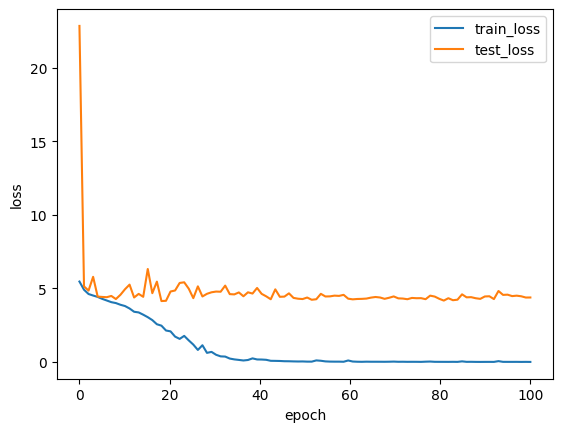

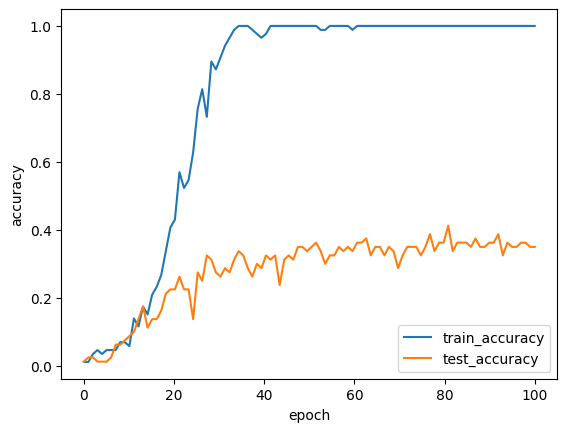

In [9]:
def draw_(x, train_Y, test_Y, ylabel):
    plt.plot(x, train_Y, label='train_' + ylabel, linewidth=1.5)
    plt.plot(x, test_Y, label='test_' + ylabel, linewidth=1.5)
    plt.xlabel('epoch')
    plt.ylabel(ylabel)
    plt.legend()  # 加上图例
    plt.savefig('./'+ylabel+'.png')
    plt.show()



# 绘制loss曲线
x = np.linspace(0, len(train_loss_list), len(train_loss_list))
draw_(x, train_loss_list, test_loss_list, 'loss')
draw_(x, train_acc_list, test_acc_list, 'accuracy')

In [11]:
torch.save(net, "./model.pt")

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),  # 变为tensor
     # 对数据按通道进行标准化，即减去均值，再除以方差, [0-1]->[-1,1]
     transforms.Normalize(mean=[0.4686, 0.4853, 0.5193], std=[0.1720, 0.1863, 0.2175])
     ]
)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, label, trans):
        self.len = len(data)
        self.data = data
        self.label = label
        self.trans = trans

    def __getitem__(self, index):  # 根据索引返回数据和对应的标签
        return self.trans(self.data[index]), self.label[index]

    def __len__(self):
        return self.len


# 调用自己创建的Dataset
train_dataset = MyDataset(train_data, train_labels, transform)
test_dataset = MyDataset(test_data, test_labels, transform)

# 生成data loader
train_iter = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

In [33]:
model = torch.load("./model.pt")
model.eval()
img = Image.open("D:/aaaaaaaaaaaaaaaaa/nus/fyp/Q2A-master/Q2A-master/encoder/configs/train/bicycle_g8h94/images/bicycle-user.jpg").convert("RGB")  # img shape: (120, 85, 3) 高、宽、通道
img = img.resize((64, 64), Image.ANTIALIAS)  # 宽、高
data=[]
data.append(img)
label=[]
label.append(1)
train_dataset = MyDataset(data, label, transform)

train_iter = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0
)
for data, target in train_iter:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    output = output.reshape(output.shape[0],1)
    print(output)
    prediction=torch.argmax(output)
    # _, prediction = torch.max(output, dim=1)
    # prediction=prediction.cpu()
    # print(prediction)
    # prediction = prediction.numpy()[0]
    print(prediction)

tensor([[-1.9690],
        [ 6.3604],
        [-3.8278],
        [-1.2188],
        [21.2518],
        [-2.0500],
        [-2.9523],
        [ 3.0764],
        [-4.0141],
        [ 1.9290],
        [-0.8069],
        [ 6.8149],
        [-2.0128],
        [ 0.2217],
        [-4.1256],
        [-3.6803],
        [ 3.1191],
        [-1.9025],
        [ 2.8264],
        [ 1.3222],
        [-5.4291],
        [ 2.2751],
        [-1.0715],
        [ 1.8027],
        [-4.2632],
        [-1.3508],
        [-1.7561],
        [ 7.8243],
        [ 2.2372],
        [ 5.8363],
        [-2.9629],
        [-3.7306],
        [ 6.8932],
        [ 3.2095],
        [ 0.4880],
        [-1.1550],
        [-2.3469],
        [-0.8806],
        [-0.2054],
        [ 0.9674],
        [-4.5230],
        [ 4.7652],
        [-0.0688],
        [-3.1219],
        [ 2.2917],
        [-4.0371],
        [ 6.4076],
        [ 0.4200],
        [ 2.4114],
        [ 3.4084],
        [-5.3392],
        [-6.1299],
        [ 0.

E:\anaconda\envs\dl\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  after removing the cwd from sys.path.


In [34]:
print(classes[prediction])

bicycle_g8h94


In [84]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms

import torchvision.datasets as datasets
from torch.autograd import Variable
from torchvision.models import densenet121

# 设置全局参数
modellr = 1e-4
BATCH_SIZE =  2
EPOCHS = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据预处理

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

])

class MyDataset(Dataset):
    def __init__(self, data, label, trans):
        self.len = len(data)
        self.data = data
        self.label = label
        self.trans = trans

    def __getitem__(self, index):  # 根据索引返回数据和对应的标签
        return self.trans(self.data[index]), self.label[index]

    def __len__(self):
        return self.len


# 调用自己创建的Dataset
train_dataset = MyDataset(train_data, train_labels, transform)
test_dataset = MyDataset(test_data, test_labels, transform)

# 生成data loader
train_iter = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)
test_iter = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

# 导入数据
# train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

# 实例化模型并且移动到GPU
criterion = nn.CrossEntropyLoss()
model_ft = densenet121(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 80)
model_ft.to(DEVICE)
# 选择简单暴力的Adam优化器，学习率调低
optimizer = optim.Adam(model_ft.parameters(), lr=modellr)


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    modellrnew = modellr * (0.1 ** (epoch // 50))
    print("lr:", modellrnew)
    for param_group in optimizer.param_groups:
        param_group['lr'] = modellrnew


# 定义训练过程

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    sum_loss = 0
    total_num = len(train_loader.dataset)
    print(total_num, len(train_loader))
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(target).to(device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print_loss = loss.data.item()
        sum_loss += print_loss
        if (batch_idx + 1) % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                       100. * (batch_idx + 1) / len(train_loader), loss.item()))
    ave_loss = sum_loss / len(train_loader)
    print('epoch:{},loss:{}'.format(epoch, ave_loss))


# 验证过程
def val(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total_num = len(test_loader.dataset)
    print(total_num, len(test_loader))
    with torch.no_grad():
        for data, target in test_loader:
            data, target = Variable(data).to(device), Variable(target).to(device)
            output = model(data)
            loss = criterion(output, target)
            _, pred = torch.max(output.data, 1)
            correct += torch.sum(pred == target)
            print_loss = loss.data.item()
            test_loss += print_loss
        correct = correct.data.item()
        acc = correct / total_num
        avgloss = test_loss / len(test_loader)
        print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            avgloss, correct, len(test_loader.dataset), 100 * acc))


# 训练

for epoch in range(1, EPOCHS + 1):
    adjust_learning_rate(optimizer, epoch)
    train(model_ft, DEVICE, train_iter, optimizer, epoch)
    val(model_ft, DEVICE, test_iter)
torch.save(model_ft, 'model1.pth')

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.